In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
electronics_data = pd.read_csv('/content/drive/MyDrive/Revolutinaries/20191226-items.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Revolutinaries/20191226-reviews.csv')
reviews = reviews.drop('rating',1)
reviews = reviews.drop('title',1)
electronics_data = pd.merge(electronics_data,reviews,on='asin')
electronics_data = electronics_data.drop('totalReviews',1) 

In [ ]:
electronics_data.head()

,asin,brand,title,url,image,rating,reviewUrl,price,originalPrice,name,date,verified,body,helpfulVotes
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,0.0,0.0,Janet,"October 11, 2005",False,I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,0.0,0.0,Luke Wyatt,"January 7, 2004",False,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,0.0,0.0,Brooke,"December 30, 2003",False,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,0.0,0.0,amy m. teague,"March 18, 2004",False,"I love the phone and all, because I really did...",1.0
4,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,0.0,0.0,tristazbimmer,"August 28, 2005",False,The phone has been great for every purpose it ...,1.0


In [ ]:
electronics_data.shape

(67986, 14)

In [ ]:
electronics_data.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
price            float64
originalPrice    float64
name              object
date              object
verified            bool
body              object
helpfulVotes     float64
dtype: object

In [ ]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67986 entries, 0 to 67985
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   asin           67986 non-null  object 
 1   brand          67786 non-null  object 
 2   title          67986 non-null  object 
 3   url            67986 non-null  object 
 4   image          67986 non-null  object 
 5   rating         67986 non-null  float64
 6   reviewUrl      67986 non-null  object 
 7   price          67986 non-null  float64
 8   originalPrice  67986 non-null  float64
 9   name           67984 non-null  object 
 10  date           67986 non-null  object 
 11  verified       67986 non-null  bool   
 12  body           67965 non-null  object 
 13  helpfulVotes   27215 non-null  float64
dtypes: bool(1), float64(4), object(9)
memory usage: 7.3+ MB


In [ ]:
electronics_data.describe()['rating'].T

count    67986.000000
mean         3.766826
std          0.429197
min          1.000000
25%          3.500000
50%          3.800000
75%          4.100000
max          5.000000
Name: rating, dtype: float64

In [ ]:
print('Minimum rating is: %d' %(electronics_data.rating.min()))
print('Maximum rating is: %d' %(electronics_data.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [ ]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 asin                 0
brand              200
title                0
url                  0
image                0
rating               0
reviewUrl            0
price                0
originalPrice        0
name                 2
date                 0
verified             0
body                21
helpfulVotes     40771
dtype: int64


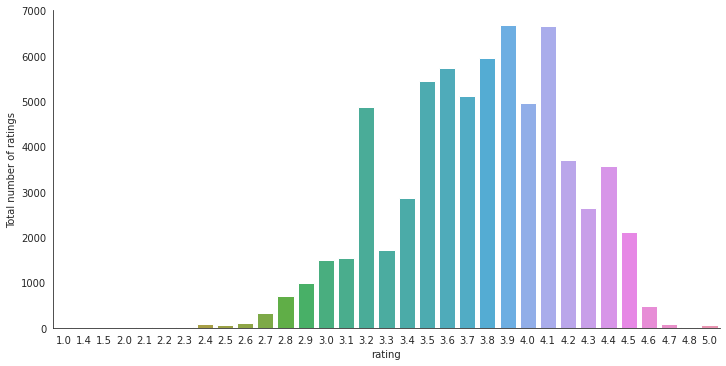

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(electronics_data.name.unique()))
print("Total No of products  :", len(np.unique(electronics_data.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 67986
Total No of Users   : 47324
Total No of products  : 720


In [ ]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = electronics_data.groupby(by='name')['rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

name
Amazon Customer    6507
Kindle Customer     360
Chris                89
John                 87
Michael              77
Name: rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()

count    47323.000000
mean         1.436595
std         30.005139
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       6507.000000
Name: rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

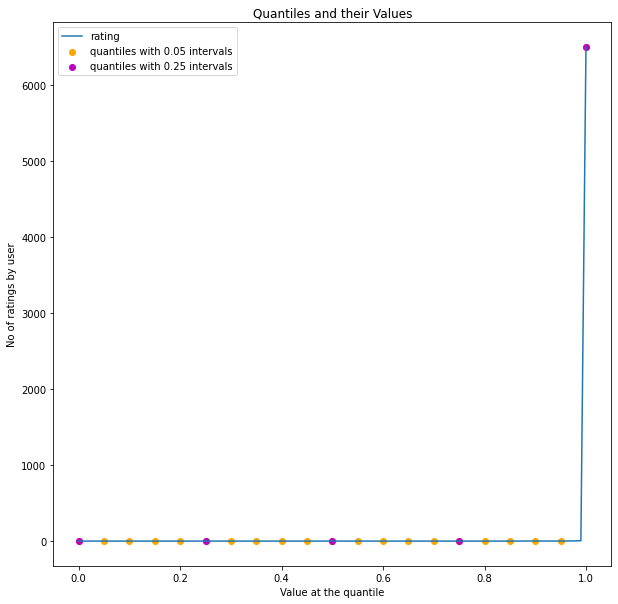

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 11



In [ ]:
new_df=electronics_data.groupby("asin").filter(lambda x:x['rating'].count() >=50)
new_df

,asin,brand,title,url,image,rating,reviewUrl,price,originalPrice,name,date,verified,body,helpfulVotes
126,B002UHS0UI,Motorola,Verizon Wireless Motorola RAZR V3m - Silver,https://www.amazon.com/Verizon-Wireless-Motoro...,https://m.media-amazon.com/images/I/61pVtPaTkM...,2.7,https://www.amazon.com/product-reviews/B002UHS0UI,0.0,0.0,Joyful,"August 25, 2016",True,First of all I need to delete my lst review si...,24.0
127,B002UHS0UI,Motorola,Verizon Wireless Motorola RAZR V3m - Silver,https://www.amazon.com/Verizon-Wireless-Motoro...,https://m.media-amazon.com/images/I/61pVtPaTkM...,2.7,https://www.amazon.com/product-reviews/B002UHS0UI,0.0,0.0,Educated Consumer,"November 21, 2019",True,I made a three hour international call and it ...,NaN
128,B002UHS0UI,Motorola,Verizon Wireless Motorola RAZR V3m - Silver,https://www.amazon.com/Verizon-Wireless-Motoro...,https://m.media-amazon.com/images/I/61pVtPaTkM...,2.7,https://www.amazon.com/product-reviews/B002UHS0UI,0.0,0.0,mike k,"May 1, 2019",True,Horrible purchase. Came today and first thing ...,1.0
129,B002UHS0UI,Motorola,Verizon Wireless Motorola RAZR V3m - Silver,https://www.amazon.com/Verizon-Wireless-Motoro...,https://m.media-amazon.com/images/I/61pVtPaTkM...,2.7,https://www.amazon.com/product-reviews/B002UHS0UI,0.0,0.0,Eddie Gamble,"September 5, 2018",True,After only having this phone for a month it wo...,1.0
130,B002UHS0UI,Motorola,Verizon Wireless Motorola RAZR V3m - Silver,https://www.amazon.com/Verizon-Wireless-Motoro...,https://m.media-amazon.com/images/I/61pVtPaTkM...,2.7,https://www.amazon.com/product-reviews/B002UHS0UI,0.0,0.0,Andrew,"February 14, 2015",True,The phone arrived with some scratches on the f...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67979,B081H6STQQ,Sony,Sony Xperia 1 Unlocked Smartphone and WH1000XM...,https://www.amazon.com/Sony-Smartphone-WH1000X...,https://m.media-amazon.com/images/I/51zZTAXZTP...,4.5,https://www.amazon.com/product-reviews/B081H6STQQ,948.0,0.0,Cindy Cowles,"July 17, 2019",False,Update: If you like sending and receiving pict...,2.0
67980,B081H6STQQ,Sony,Sony Xperia 1 Unlocked Smartphone and WH1000XM...,https://www.amazon.com/Sony-Smartphone-WH1000X...,https://m.media-amazon.com/images/I/51zZTAXZTP...,4.5,https://www.amazon.com/product-reviews/B081H6STQQ,948.0,0.0,Los Kositos,"October 7, 2019",False,I love my new phone. I've been dying to do a r...,1.0
67981,B081H6STQQ,Sony,Sony Xperia 1 Unlocked Smartphone and WH1000XM...,https://www.amazon.com/Sony-Smartphone-WH1000X...,https://m.media-amazon.com/images/I/51zZTAXZTP...,4.5,https://www.amazon.com/product-reviews/B081H6STQQ,948.0,0.0,jande,"August 16, 2019",False,I love the camera on this phone. The screen is...,1.0
67982,B081H6STQQ,Sony,Sony Xperia 1 Unlocked Smartphone and WH1000XM...,https://www.amazon.com/Sony-Smartphone-WH1000X...,https://m.media-amazon.com/images/I/51zZTAXZTP...,4.5,https://www.amazon.com/product-reviews/B081H6STQQ,948.0,0.0,2cool4u,"September 14, 2019",False,I've been an Xperia user for several years and...,1.0


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

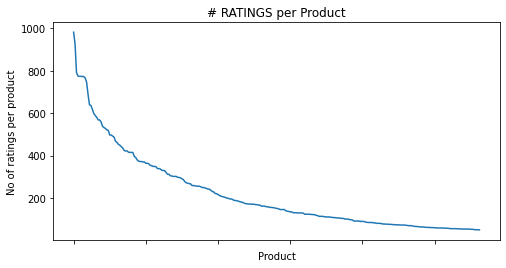

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='asin')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
new_df.groupby('asin')['rating'].mean().head()

asin
B002UHS0UI    2.7
B002WTC1NG    3.6
B0033SFV5A    3.3
B003FCO9XE    2.6
B003P2VNAQ    3.6
Name: rating, dtype: float64

In [ ]:
new_df.groupby('asin')['rating'].mean().sort_values(ascending=False).head()

asin
B07K1M36CM    4.6
B07YQ58NPF    4.6
B07YZLRS3Z    4.6
B07YJHXZT6    4.6
B07WW25BSV    4.6
Name: rating, dtype: float64

In [ ]:
new_df.groupby('asin')['rating'].count().sort_values(ascending=False).head()

asin
B00F2SKPIM    981
B00836Y6B2    925
B07FZH9BGV    791
B01D1J9BGU    775
B018OMP8ES    773
Name: rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['rating'].count())
ratings_mean_count['score'] = (0.5*ratings_mean_count['rating_counts'])+(0.5*ratings_mean_count["rating"])

In [ ]:
ratings_mean_count.head()

,rating,rating_counts,score
asin,,,
B002UHS0UI,2.7,207,104.85
B002WTC1NG,3.6,348,175.80
B0033SFV5A,3.3,56,29.65
B003FCO9XE,2.6,77,39.80
B003P2VNAQ,3.6,67,35.30


In [ ]:
ratings_mean_count['score'].max()

492.45000000000005

<Figure size 576x432 with 0 Axes>

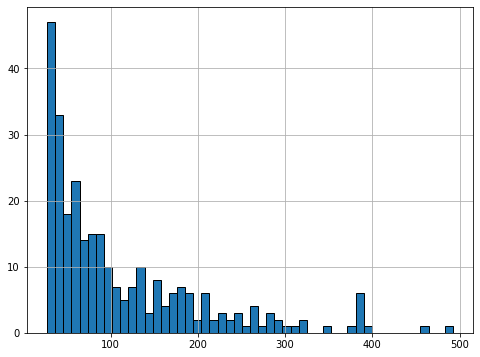

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['score'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

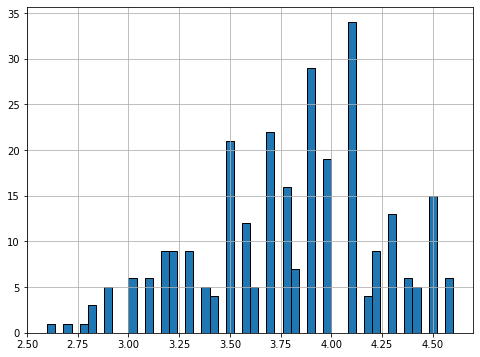

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

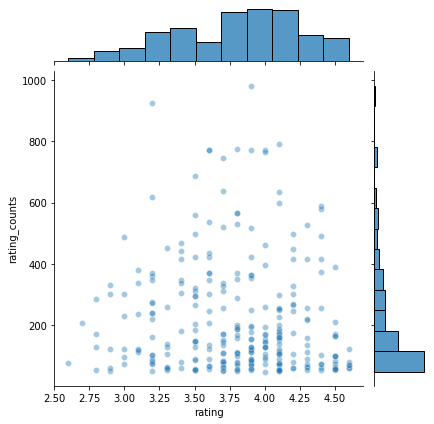

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

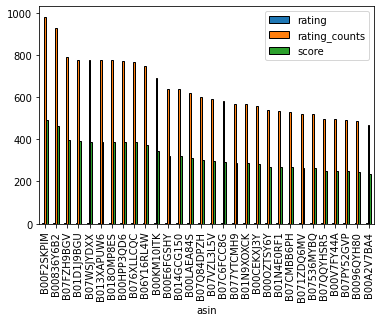

In [ ]:
popular_products = pd.DataFrame(ratings_mean_count)
most_popular = popular_products.sort_values('score', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [ ]:
most_popular.head(10)

,rating,rating_counts,score
asin,,,
B00F2SKPIM,3.9,981,492.45
B00836Y6B2,3.2,925,464.10
B07FZH9BGV,4.1,791,397.55
B01D1J9BGU,3.8,775,389.40
B07WSJYDXX,3.9,773,388.45
B013XAPUW6,3.6,773,388.30
B018OMP8ES,3.6,773,388.30
B00HPP3QD6,4.0,772,388.00
B076XLLCQC,4.0,766,385.00


In [ ]:
!pip install surprise


     |████████████████████████████████| 11.8 MB 23.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617775 sha256=ab6f90ccc2efd22d45c43fb03c66f6b9286a0eb571656349ab9ff82708f3d566
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split


In [ ]:
new_df = electronics_data[['name','asin','rating']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred = algo.test(testset)

In [ ]:
test_pred

[Prediction(uid='Amazon Customer', iid='B076MB4CYN', r_ui=3.5, est=3.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='Attila Csupo', iid='B071H9KKKF', r_ui=4.0, est=3.7664425299432653, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='M. Dipaola', iid='B00A2V7ULY', r_ui=3.0, est=3.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='Kenneth Ellison', iid='B06XR8G1TX', r_ui=3.5, est=3.7664425299432653, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Mark', iid='B00LAEA84S', r_ui=3.2, est=3.1999999999999997, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='mina', iid='B00F1HVZ0Q', r_ui=3.7, est=3.7664425299432653, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Mainnin', iid='B01N4E0RF1', r_ui=3.8, est=3.7664425299432653, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.3510


0.35101779393237514

In [ ]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='rating', index='name', columns='asin', fill_value=0)
ratings_matrix.head()

asin,B0000SX2UC,B0009N5L7K,B000SKTZ0S,B001AO4OUC,B001DCJAJG,B001GQ3DJM,B0029F2O3A,B002AS9WEA,B002UHS0UI,B002WTC1NG,B0033SFV5A,B003FCO9XE,B003P2VNAQ,B003W646YK,B003XREZ4O,B0046REOWS,B004C7NVD0,B004GLQTG8,B004H23JXW,B004MK9VLS,B004YBP8EY,B005B3OXWC,B006OU39QW,B006VH79R8,B00727AODC,B007LU0HU0,B007X6FFLS,B0081TDISI,B00836Y6B2,B008PAW5EQ,B0096DERAG,B0096QYH80,B009LRMQTG,B00A2V7BA4,B00A2V7ULY,B00A408AF8,B00A7F57EM,B00A7F5M9W,B00ACZ0DUA,B00B5081MI,B00BV1MVJ0,B00CEKXJ3Y,B00CEKXZA6,B00CGIULGC,B00CQAODG4,B00CS2ZWKQ,B00D35Z6OE,B00D99ZBR6,B00E45043A,B00E6FGSHY,B00E8TGT1S,B00EP2BN00,B00F1HVZ0Q,B00F2SKPIM,B00F3JPKCG,B00F9RRVUG,B00FTV382C,B00G9G0HTI,B00HE5834Y,B00HPP3QD6
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#1reader,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
&amp;Drea,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
05stram,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
1 Stop 4 Whats HOT,0,3,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
101345,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0


In [ ]:
ratings_matrix.shape

(8639, 60)

In [ ]:
X = ratings_matrix.T
X.head()

name,#1reader,&amp;Drea,05stram,1 Stop 4 Whats HOT,101345,1111,11WyoFan,1607jh,1973 AMCJavelin,1988AmazonCustomer,1stCivDiv,1stKlass,1treasurehunter,240Brick,28Alpha3,2ACTIVE BOYS,2BitPixel,2ndadamlike,31f,321andme,411,49erJoe,49ergal777,51audio,671buyer,707smartshop,816-536-1609,906TechTalk,@TSDiamondFire,A,A Bateman,A Charlie brown,A Consumer,A Customer,A J Lewis,A Lynchy,A Shopper,A movie fan,A normal Dude,A techno geek,...,wkwebb,wmy76ram,workingman,xenojoey,xinghan wang,xiulan chi,xlayn,yang,yessika sanchez,yezenia04,yiwei,yohendry zabala,yoldy,yolibel,yong,your friendly mac book user,your mom,yous,yu shao,yuhao zhang,yulimir,yurih,yvette,zack bouma,zahava frist,zahir,zaphod,zazen_tao,zeb reneau,zekarias,zhang,zia165,zooranger,zoraida romero,zqy,zt,zzzzzzzzzz,~RCL~,Ángel Rafael Gonzalez Carvajal,小贝❤️ 星星
asin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B0000SX2UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0009N5L7K,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000SKTZ0S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0
B001AO4OUC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B001DCJAJG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.shape

(60, 8639)

In [ ]:
X1 = X

In [ ]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(60, 10)

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape
correlation_matrix

(60, 60)

array([[ 1.        , -0.03995687,  0.63532906, ...,  0.69680192,
         0.77687009,  0.36595017],
       [-0.03995687,  1.        , -0.32760169, ..., -0.13138795,
        -0.31121836,  0.01415589],
       [ 0.63532906, -0.32760169,  1.        , ...,  0.89511122,
         0.87517364,  0.22406436],
       ...,
       [ 0.69680192, -0.13138795,  0.89511122, ...,  1.        ,
         0.8377383 ,  0.25972106],
       [ 0.77687009, -0.31121836,  0.87517364, ...,  0.8377383 ,
         1.        ,  0.42823927],
       [ 0.36595017,  0.01415589,  0.22406436, ...,  0.25972106,
         0.42823927,  1.        ]])

In [ ]:
X.index[45]

'B00CS2ZWKQ'

In [ ]:
i = "B00CS2ZWKQ"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

45

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape
correlation_product_ID

(60,)

array([ 7.62625130e-01, -1.52989889e-01,  8.99351843e-01,  9.00387723e-01,
        8.19420961e-01, -1.99031055e-01,  3.20920891e-01,  9.70897686e-01,
        8.04412384e-01,  7.14059163e-02,  7.52258315e-01,  9.33356261e-01,
        9.30927745e-01,  9.59913570e-01,  7.48248070e-01,  9.42561062e-01,
        8.47723257e-01,  9.56381968e-01,  9.24909740e-01,  9.14807799e-01,
        2.43511175e-01,  4.33168875e-01,  9.54634934e-01,  9.70539281e-01,
        9.44460437e-01, -1.45524012e-01,  8.90398116e-01,  2.69962122e-01,
       -5.28509407e-02,  9.28410495e-01,  9.72051676e-01, -4.08951099e-01,
        8.96783199e-01,  4.67545976e-02,  6.87833588e-02,  8.47115971e-01,
        9.31933698e-01,  5.90527404e-01,  7.68206432e-01,  8.75562305e-01,
        9.30008165e-01, -3.58845399e-02, -5.27324325e-04,  8.27627046e-01,
        8.65154669e-01,  1.00000000e+00,  8.59448180e-01,  9.49164034e-01,
        8.28218726e-02,  6.18349266e-02,  1.91134315e-01,  8.73568756e-01,
        7.04516377e-01,  

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['B0000SX2UC',
 'B000SKTZ0S',
 'B001AO4OUC',
 'B001DCJAJG',
 'B002AS9WEA',
 'B002UHS0UI',
 'B0033SFV5A',
 'B003FCO9XE',
 'B003P2VNAQ',
 'B003W646YK',
 'B003XREZ4O',
 'B0046REOWS',
 'B004C7NVD0',
 'B004GLQTG8',
 'B004H23JXW',
 'B004MK9VLS',
 'B006OU39QW',
 'B006VH79R8',
 'B00727AODC',
 'B007X6FFLS',
 'B008PAW5EQ',
 'B0096DERAG',
 'B009LRMQTG',
 'B00A408AF8']